In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
titanic_df = pd.read_csv('titanic.csv', index_col='PassengerId')

Column 'Ticket' is irrelevant to the task and probably could be omitted. Column name can be dropped as well. The function DatFrame.convert_dtypes() applied the right type to columns.

In [2]:
titanic_df.drop(columns=['Name', 'Ticket'], inplace=True)
titanic_df = titanic_df.convert_dtypes()
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    Int64  
 1   Pclass    891 non-null    Int64  
 2   Sex       891 non-null    string 
 3   Age       714 non-null    Float64
 4   SibSp     891 non-null    Int64  
 5   Parch     891 non-null    Int64  
 6   Fare      793 non-null    Float64
 7   Cabin     204 non-null    string 
 8   Embarked  889 non-null    string 
dtypes: Float64(2), Int64(4), string(3)
memory usage: 74.8 KB


## Cleaning the Na values

There are between 0-3 Na values in each row. The missing values are of categories: Age, Fare, Cabin and Embarked, which I all find important to the task, so I won't delete any column.

### The Na's in categorical column 'Embarked' will be replaced with mode, because S id dominating and not many values need to be replaced.


In [3]:
titanic_df['Embarked'].value_counts()
titanic_df['Embarked'] = titanic_df['Embarked'].fillna(value='S')

### The Na's in categorical column 'Cabin' will be replaced with a new category 'Other' since no value is dominating.

In [4]:
titanic_df['Cabin'].value_counts()
titanic_df['Cabin'].isna().value_counts()
titanic_df['Cabin'] = titanic_df['Cabin'].fillna(value='Unknown')


### The numerical column 'Age' is of type float, I checked if there are any values with a fractional part. Some values like '0.42' or '0.67' make no sense for me. It should be of type integer. The data distribution is asymmetrical, right sided, so I will replace all the na values with median.

In [5]:
is_nan_series = titanic_df['Age'].isna()
is_integer_series = titanic_df['Age'].apply(float.is_integer)
is_nan_or_integer_series = is_nan_series | is_integer_series
is_nan_or_integer_series.value_counts()

Age
True     866
False     25
Name: count, dtype: int64

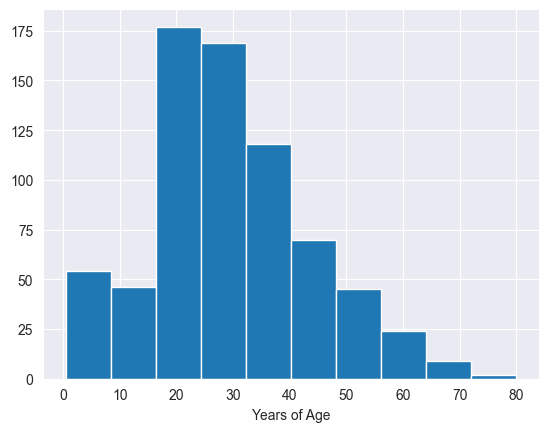

In [6]:
plt.hist(titanic_df['Age'], bins=10)
plt.xlabel('Years of Age')
plt.show()

In [7]:
age_median = titanic_df['Age'].median()
titanic_df['Age'] = titanic_df['Age'].fillna(age_median)

### Numerical column 'Fare' of type float should be rounded to 2 decimal places. The data distribution is strongly asymmetrical so na values will be replaced with median.

In [8]:
titanic_df['Fare'] = titanic_df['Fare'].apply(lambda x: round(x,2))

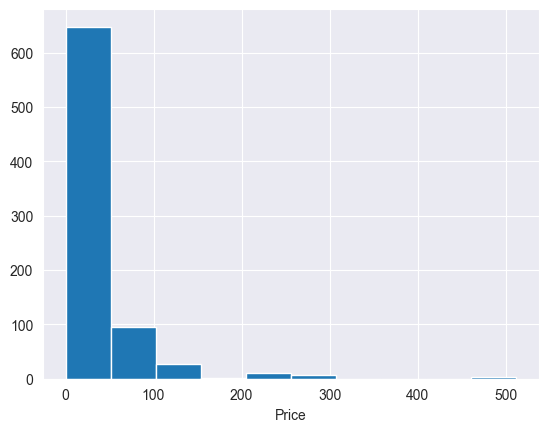

In [9]:
plt.hist(titanic_df['Fare'])
plt.xlabel('Price')
plt.show()

In [10]:
fare_median = titanic_df['Fare'].median()
titanic_df['Fare'] = titanic_df['Fare'].fillna(fare_median)

# Data Enrichment

### Cabin Column
Having the cabin column we can determinate on which deck was the cabin

In [11]:
titanic_df.head()
def cabin_to_deck(x):
    if x == "Unknown":
        return x
    elif 'A' in x:
        return 'A'
    elif 'B' in x:
        return 'B'
    elif 'C' in x:
        return 'C'
    elif 'D' in x:
        return "D"
    elif 'E' in x:
        return "E"
    elif 'F' in x:
        return "F"
    elif 'G' in x:
        return 'G'
    elif 'T' in x:
        return 'T'

deck_column = pd.Series(data=titanic_df['Cabin'].apply(cabin_to_deck), index=titanic_df.index, name='Deck')
titanic_df = pd.concat([titanic_df, deck_column], axis=1)

### Adult Column
We can add a column stating if the passenger was an adult or not (under 18), using encoding 0 -> no and 1 -> yes

In [12]:
adult = pd.Series(data=titanic_df['Age'].copy(), index=titanic_df.index, name='Adult')
adult = adult.apply(lambda x: 1 if x >=18 else 0)
titanic_df = pd.concat([titanic_df, adult], axis=1)

### Encoding categorical columns
Sex column encoding: 0 -> male and 1 -> female

In [13]:
titanic_df['Sex'] = titanic_df['Sex'].apply(lambda x: 0 if x == 'male' else 1)

Cabin column encoding with a mapping

In [14]:
deck_mapping = {
    'T':1,
    'A':2,
    'B':3,
    'C':4,
    'D':5,
    'E':6,
    'F':7,
    'G':8,
    'Unknown':0
}
titanic_df['Deck'] = titanic_df['Deck'].map(deck_mapping)
titanic_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Deck,Adult
PassengerId,,,,,,,,,,,
1,0,3,0,22.0,1,0,7.25,Unknown,S,0,1
2,1,1,1,38.0,1,0,71.28,C85,C,4,1
3,1,3,1,26.0,0,0,7.92,Unknown,S,0,1
4,1,1,1,35.0,1,0,53.10,C123,S,4,1
5,0,3,0,35.0,0,0,8.05,Unknown,S,0,1


I will use label encoding on the cabin column since one hot encoding would create too many categories.


In [15]:
print("Category Mapping:", dict(enumerate(titanic_df['Cabin'].astype('category').cat.categories)))
titanic_df['Cabin'] = titanic_df['Cabin'].astype('category').cat.codes


Category Mapping: {0: 'A10', 1: 'A14', 2: 'A16', 3: 'A19', 4: 'A20', 5: 'A23', 6: 'A24', 7: 'A26', 8: 'A31', 9: 'A32', 10: 'A34', 11: 'A36', 12: 'A5', 13: 'A6', 14: 'A7', 15: 'B101', 16: 'B102', 17: 'B18', 18: 'B19', 19: 'B20', 20: 'B22', 21: 'B28', 22: 'B3', 23: 'B30', 24: 'B35', 25: 'B37', 26: 'B38', 27: 'B39', 28: 'B4', 29: 'B41', 30: 'B42', 31: 'B49', 32: 'B5', 33: 'B50', 34: 'B51 B53 B55', 35: 'B57 B59 B63 B66', 36: 'B58 B60', 37: 'B69', 38: 'B71', 39: 'B73', 40: 'B77', 41: 'B78', 42: 'B79', 43: 'B80', 44: 'B82 B84', 45: 'B86', 46: 'B94', 47: 'B96 B98', 48: 'C101', 49: 'C103', 50: 'C104', 51: 'C106', 52: 'C110', 53: 'C111', 54: 'C118', 55: 'C123', 56: 'C124', 57: 'C125', 58: 'C126', 59: 'C128', 60: 'C148', 61: 'C2', 62: 'C22 C26', 63: 'C23 C25 C27', 64: 'C30', 65: 'C32', 66: 'C45', 67: 'C46', 68: 'C47', 69: 'C49', 70: 'C50', 71: 'C52', 72: 'C54', 73: 'C62 C64', 74: 'C65', 75: 'C68', 76: 'C7', 77: 'C70', 78: 'C78', 79: 'C82', 80: 'C83', 81: 'C85', 82: 'C86', 83: 'C87', 84: 'C90', 8

### Outliers

For detecting outliers I will use boxplot. No outliers below age zero, some outliers above the age of 65. It says that old people were rare on titanic.

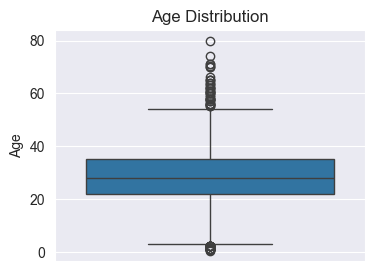

<Figure size 640x480 with 0 Axes>

In [16]:
plt.figure(figsize = (4,3))
sns.boxplot(data=titanic_df['Age'])
plt.title('Age Distribution')
plt.show()
plt.tight_layout()
plt.show()

SibSp and Parch columns have a lot of outliers, because most of the passengers had between 0-1 siblings/spouses and 0 parents/children there.

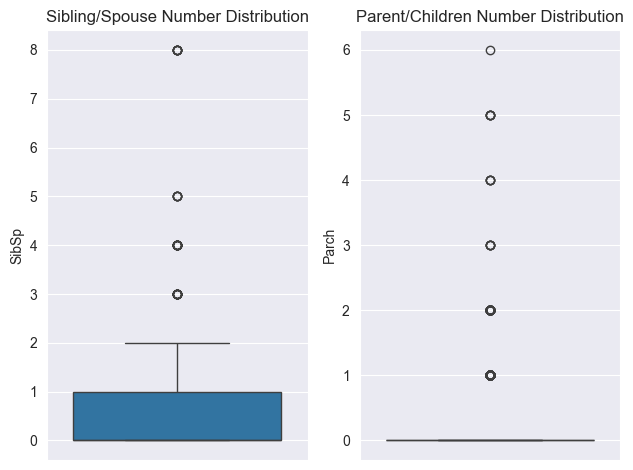

<IntegerArray>
[0, 1, 2, 5, 3, 4, 6]
Length: 7, dtype: Int64

In [20]:
plt.figure()
plt.subplot(1,2,1)
sns.boxplot(data=titanic_df['SibSp'])
plt.title('Sibling/Spouse Number Distribution')
plt.subplot(1,2,2)
sns.boxplot(data=titanic_df['Parch'])
plt.title('Parent/Children Number Distribution')
plt.tight_layout()
plt.show()

We also see a lot of outliers on the Fare Distribution. The deck distribution is corrupted because every missing Cabin data resulted in the Unknown Category, which translated to 0 in Deck Column Mapping.

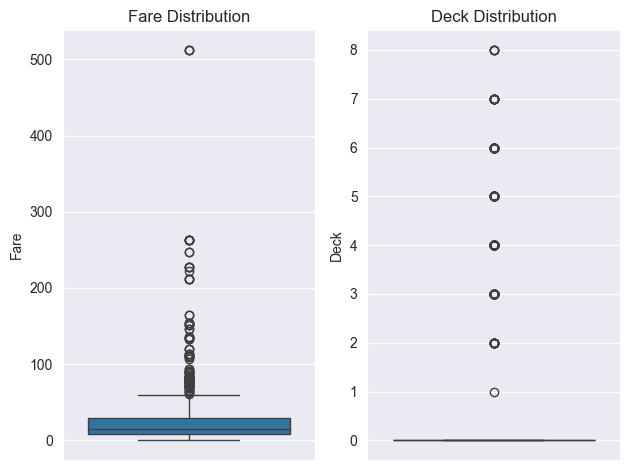

In [22]:
plt.figure()
plt.subplot(1,2,1)
sns.boxplot(data=titanic_df['Fare'])
plt.title('Fare Distribution')
plt.subplot(1,2,2)
sns.boxplot(data=titanic_df['Deck'])
plt.title('Deck Distribution')
plt.tight_layout()
plt.show()

# Correlations
### Did age affect the survival rate?
Above age circa 65 everyone died except 1 person. Probably because they saved women and children first.

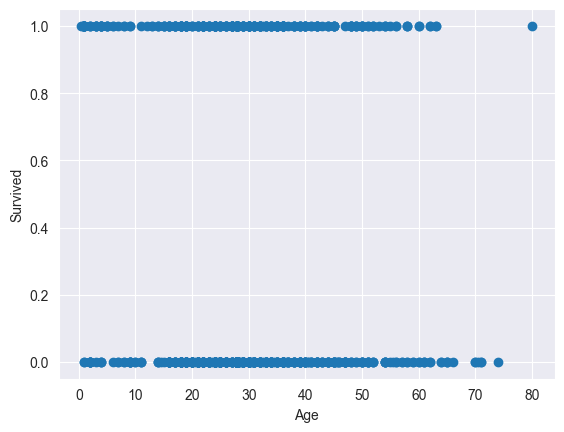

In [24]:
plt.figure()
plt.scatter(titanic_df['Age'], titanic_df['Survived'])
plt.xlabel('Age')
plt.ylabel('Survived')
plt.show()


### Did age affect the fare of the ticket?
The pricier the tickets the more age was close to 30-40, adults have the most money to spend on a cruise like this or senior/children tickets had a discount

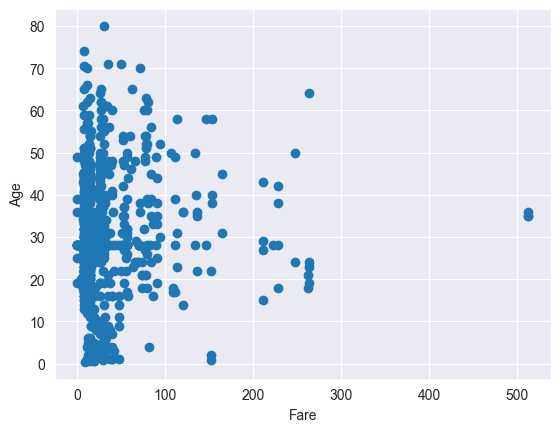

In [28]:
plt.figure()
plt.scatter(titanic_df['Fare'], titanic_df['Age'])
plt.xlabel('Fare')
plt.ylabel('Age')
plt.show()

### What Deck was the most expensive
The decks 3 and 4 were the most expensive with the data that we have.

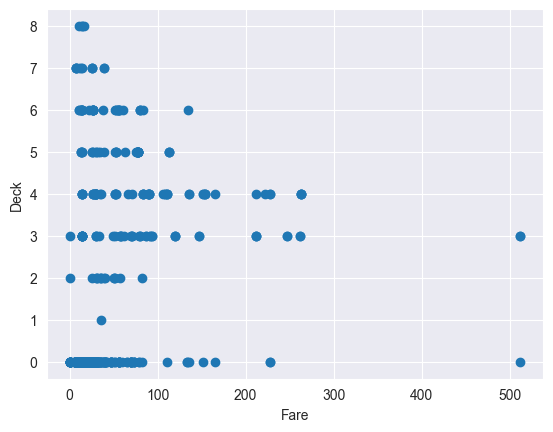

In [29]:
plt.figure()
plt.scatter(titanic_df['Fare'], titanic_df['Deck'])
plt.xlabel('Fare')
plt.ylabel('Deck')
plt.show()